# Inspired by Quantum tree generator improves QAOA state-of-the-art for the knapsack problem  Paul Christiansen et al. 2024

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from __future__ import annotations
from typing import List
import math
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import IntegerComparator
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.circuit.library import WeightedAdder, WeightedSumGate
from qiskit.quantum_info import DensityMatrix, partial_trace, Statevector

In [2]:
from collections import defaultdict

def build_qkp_cost_hamiltonian_without_constraint(n_items, profits):
    """
    Build the Hamiltonian qubo to the QKP just including the profits.
    Returns a sparsepauliop to use in qaoa.
    """

    pauli_dict = defaultdict(float)

    # Términos cuadráticos
    for i in range(n_items):
        for j in range(i, n_items):
            pauli_i = ["I"] * n_items
            pauli_i[i] = "Z"
            coeff = - 1/4 * profits[i][j]
            if i == j: 
                pauli_str = "".join(pauli_i)[::-1]
                pauli_dict[pauli_str] = coeff 
            else:
                pauli_j = pauli_i.copy()
                pauli_j[j] = "Z"
                pauli_str = "".join(pauli_j)[::-1]
                pauli_dict[pauli_str] += coeff * 2
        

    # Términos lineales
    for i in range(n_items):
        pauli_i = ["I"] * n_items
        pauli_i[i] = "Z"
        pauli_str = "".join(pauli_i)[::-1] 
        coeff = 0
        for j in range(0, n_items):
            coeff += 1/2 * profits[i][j]
        pauli_dict[pauli_str] += coeff

  
    return SparsePauliOp.from_list([(p, coeff) for p, coeff in pauli_dict.items() if abs(coeff) > 1e-8])

In [3]:
def _pad_with_identity(op: SparsePauliOp, n_total: int) -> SparsePauliOp:
    """Devuelve  op ⊗ I_(ancillas)  para igualar qubit‑count con el circuito."""
    n_sys = op.num_qubits
    ancillas = n_total - n_sys
    if ancillas == 0:
        return op
    # Identidad sobre 'ancillas' qubits (últimos, porque se añadieron después)
    id_anc = SparsePauliOp.from_list([("I" * ancillas, 1)])
    return id_anc.tensor(op)  #  H  ⊗  I_anc


In [4]:
# n_items = 4
# weights = [1, 1, 1, 1]
# profits = np.array([[1, 1, 5, 1],
#                     [1, 7, 3, 0],
#                     [5, 3, 7, 4],
#                     [1, 0, 4, 1]]
#                     )
# capacity = 3
# real_solution = np.array([0, 1, 1, 1])

In [5]:
n_items = 7
weights = [25, 5, 22, 16, 1, 26, 34] 

profits = np.array([[45, 0, 61, 0, 0, 58, 0],
                      [0, 45, 28, 64, 68, 0, 0],
                      [61, 28, 37, 55, 32, 14, 30],
                      [0, 64, 55, 24, 4, 52, 30],
                      [0, 68, 32, 4, 39, 25, 0],
                      [58, 0, 14, 52, 25, 4, 0],
                      [0, 0, 30, 30, 0, 0, 19]])
capacity = 95
real_solution = [1, 1, 1, 1, 1, 1, 0]

In [6]:
# n_items = 7
# weights = [12, 32, 10, 18, 18, 4, 4]
# profits = np.array([[22, 52, 42, 49, 64, 0, 55],
#                       [52, 0, 0, 11, 40, 0, 51],
#                       [42, 0, 0, 12, 4, 20, 44],
#                       [49, 11, 12, 35, 0, 19, 31],
#                       [64, 40, 4, 0, 73, 26, 0],
#                       [0, 0, 20, 19, 26, 13, 67],
#                       [55, 51, 44, 31, 0, 67, 0]])
# capacity = 84
# real_solution = np.array([1, 1, 1, 0, 1, 1, 1])

In [7]:
# n_items = 7
# weights = [22, 2, 18, 23, 14, 16, 37]
# profits = np.array([[75, 9, 37, 41, 0, 0, 44],
#                     [9, 54, 27, 67, 0, 13, 0],
#                     [37, 27, 13, 23, 36, 41, 0],
#                     [41, 67, 23, 47, 13, 0, 0],
#                     [0, 0, 36, 13, 38, 0, 33],      
#                     [0, 13, 41, 0, 0, 28, 0],
#                     [44, 0, 0, 0, 33, 0, 30]])
# capacity = 120
# real_solution = np.array([1, 1, 1, 1, 1, 0, 1])

In [8]:
# n_items = 7
# weights = [37, 10, 24, 27, 11, 19, 35]
# profits = np.array([[44, 64, 64, 70, 47, 47, 0],
#                     [64, 47, 0, 0, 0, 41, 54],
#                     [64, 0, 1, 11, 12, 8, 15],
#                     [70, 0, 11, 0, 6, 2, 28],
#                     [47, 0, 12, 6, 21, 0, 0],
#                     [47, 41, 8, 2, 0, 46, 15],
#                     [0, 54, 15, 28, 0, 15, 39]])
# capacity = 85
# real_solution = [1, 1, 0, 0, 1, 1, 0] 

In [9]:
# n_items = 10
# weights = [34, 16, 24, 36, 1, 27, 16, 24, 33, 12]
# profits = np.array([[53, 72, 52, 0, 10, 21, 8, 0, 0, 46],
#                     [72, 41, 13, 36, 72, 74, 71, 61, 0, 0],
#                     [52, 13, 17, 66, 46, 54, 0, 40, 0, 0],
#                     [0, 36, 66, 2, 18, 24, 16, 11, 11, 8],
#                     [10, 72, 46, 18, 20, 31, 35, 71, 0, 13],
#                     [21, 74, 54, 24, 31, 50, 20, 53, 0, 48],
#                     [8, 71, 0, 16, 35, 20, 47, 8, 72, 26],
#                     [0, 61, 40, 11, 71, 53, 8, 16, 25, 0],
#                     [0, 0, 0, 11, 0, 0, 72, 25, 26, 65],
#                     [46, 0, 0, 8, 13, 48, 26, 0, 65, 0]])
# capacity = 107
# real_solution = [0, 1, 0, 0, 1, 1, 1, 1, 0, 1]

In [10]:
# n_items = 12
# weights = [2, 27, 32, 13, 33, 22, 27, 11, 10, 32, 11, 9]
# profits = np.array([[ 69,  55,  48,   3,  45,  19,  45,  54,   0,  17,  68,   0],
#                     [ 55,  31,   7,  58,  49,  24,  43,   0,  45,  22,  31,  69],
#                     [ 48,   7,   0,  11,   1,  57,  35,   0,  69,  16,  68,  48],
#                     [  3,  58,  11,  19,   3,  47,   3,   0,  36,  61,  43,  45],
#                     [ 45,  49,   1,   3,  29,   0,   0,  46,  31,  30,  73,   0],
#                     [ 19,  24,  57,  47,   0,  72,  39,  40,  25,   0,  47,  61],
#                     [ 45,  43,  35,   3,   0,  39,  28,   0,  20,   0,  18,  39],
#                     [ 54,   0,   0,   0,  46,  40,   0,  34,  64,   0,   8,  37],
#                     [  0,  45,  69,  36,  31,  25,  20,  64,  65,  21,  28,   3],
#                     [ 17,  22,  16,  61,  30,   0,   0,   0,  21,  33,  30,  23],
#                     [ 68,  31,  68,  43,  73,  47,  18,   8,  28,  30,  24,   0],
#                     [  0,  69,  48,  45,   0,  61,  39,  37,   3,  23,   0,  59]])
# capacity = 70
# real_solution = np.array([1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0])

In [1]:
from QKP.instances_generator import generate_and_save_instance

n_items = 7
r = 40 #range of coefficients
pct = 200  # Instance density     

generate_and_save_instance(n_items, r, pct, 1)

In [ ]:
#Hallar solucion rapida usando Gredy
def greedy_solution(weights, profits, capacity):
    n_items = len(weights)
    value_per_weight = [profits[i][i] / weights[i] for i in range(n_items)]
    sorted_indices = np.argsort(value_per_weight)[::-1]

    selected_items = []
    total_weight = 0
    total_value = 0

    for i in sorted_indices:
        if total_weight + weights[i] <= capacity:
            selected_items.append(i)
            total_weight += weights[i]
            total_value += profits[i][i]

    return selected_items

selected_items = greedy_solution(weights, profits, capacity)

greedy_ansatz = [0] * n_items  # Inicializar vector de solución
for i in selected_items:
    greedy_ansatz[i] = 1

biased = n_items/4

print("Greedy solution vector:", greedy_ansatz)

Selected items by greedy algorithm: [4, 1, 0, 2, 3, 5]
Greedy solution vector: [1, 1, 1, 1, 1, 1, 0]


In [12]:
from collections import defaultdict

def vizualization_solution(counts, capacity, n_items):    
    shots = sum(counts.values())           # nº de disparos realmente ejecutados
    cap_bits = capacity.bit_length()       # nº de bits usados para la capacidad
    assert all(len(k.replace(' ', '')) == n_items + cap_bits for k in counts), \
        "Alguna clave no tiene la longitud esperada"

    # -------------  construcción de la distribución -------------
    final_distribution = defaultdict(float)

    for bitstr, c in counts.items():
        # Qiskit devuelve la cadena en orden little‑endian; 
        # la invertimos para que el qubit 0 quede a la izquierda.
        bits = bitstr.replace(' ', '')[::-1]       

        item_bits = bits[:n_items]          # bits de los ítems (little‑endian)
        cap_bits_str = bits[n_items:]       # bits de capacidad   (little‑endian)

        # Si prefieres ver la solución en orden MSB‑primero:
        sol_bin = item_bits           
        cap_int = int(cap_bits_str[::-1], 2)

        prob = c / shots
        final_distribution[(sol_bin, cap_int)] += prob

    # -------------  análisis de resultados -------------
    feasible_dimension = len(final_distribution)
    solution, max_prob = max(final_distribution.items(), key=lambda kv: kv[1])
    
    return feasible_dimension, solution, max_prob, final_distribution

In [13]:
cost_hamiltonian = build_qkp_cost_hamiltonian_without_constraint(n_items, profits)
print("Hamiltonian QUBO:", cost_hamiltonian)

Hamiltonian QUBO: SparsePauliOp(['IIIIIIZ', 'IIIIZIZ', 'IZIIIIZ', 'IIIIIZI', 'IIIIZZI', 'IIIZIZI', 'IIZIIZI', 'IIIIZII', 'IIIZZII', 'IIZIZII', 'IZIIZII', 'ZIIIZII', 'IIIZIII', 'IIZZIII', 'IZIZIII', 'ZIIZIII', 'IIZIIII', 'IZZIIII', 'IZIIIII', 'ZIIIIII'],
              coeffs=[ 70.75+0.j, -30.5 +0.j, -29.  +0.j,  91.25+0.j, -14.  +0.j, -32.  +0.j,
 -34.  +0.j, 119.25+0.j, -27.5 +0.j, -16.  +0.j,  -7.  +0.j, -15.  +0.j,
 108.5 +0.j,  -2.  +0.j, -26.  +0.j, -15.  +0.j,  74.25+0.j, -12.5 +0.j,
  75.5 +0.j,  34.75+0.j])


In [14]:
from QTG.qtg_builder import QTG

circuit = QuantumCircuit(n_items)  

circuit = QTG(
        num_state_qubits=n_items,  
        weights=weights,
        y_ansatz=greedy_ansatz,  
        biased=biased,
        capacity=capacity)

# state = Statevector(circuit)
# pr = state.probabilities_dict(qargs=[i for i in range(n_items)])
# print("Probabilities:", pr)

#circuit.draw('mpl')

In [15]:
# Transpilar para el simulador

reg = ClassicalRegister(n_items+capacity.bit_length(), 'reg')
circuit.add_register(reg)
circuit.measure(circuit.qubits[0:n_items+capacity.bit_length()], reg)

simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(circuit, simulator)

# Ejecutar el circuito
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()
 
# Obtener conteos
counts = result.get_counts()

feasible_dimension, solution, max_prob, final_distribution = vizualization_solution(counts, capacity, n_items)

print("Feasible dimension:", feasible_dimension)
print("Solution with highest probability:", solution, "with probability:", max_prob)
print("All solutions with probabilities:", final_distribution) 

Feasible dimension: 108
Solution with highest probability: ('1111110', 95) with probability: 0.1586
All solutions with probabilities: defaultdict(<class 'float'>, {('0011010', 64): 0.008, ('1011110', 90): 0.058, ('1010110', 74): 0.0184, ('1000110', 52): 0.0056, ('1110100', 53): 0.0136, ('0101100', 22): 0.0038, ('1001101', 76): 0.0024, ('0110110', 54): 0.0155, ('1111100', 69): 0.0544, ('1101110', 73): 0.057, ('0011101', 73): 0.0017, ('0111110', 70): 0.0583, ('0000111', 61): 0.0006, ('1000111', 86): 0.0019, ('0110101', 62): 0.0016, ('1001100', 42): 0.0056, ('0101011', 81): 0.0015, ('1111110', 95): 0.1586, ('0111010', 69): 0.0208, ('1111000', 68): 0.0211, ('0101111', 82): 0.0066, ('1011010', 89): 0.0216, ('1110110', 79): 0.0582, ('1001110', 68): 0.0203, ('0100100', 6): 0.0024, ('1001010', 67): 0.0058, ('1100110', 57): 0.0142, ('0100101', 40): 0.0006, ('0001011', 76): 0.0005, ('1110000', 52): 0.0052, ('1010100', 48): 0.0056, ('1100101', 65): 0.0021, ('0101110', 48): 0.0156, ('1010000', 47)

In [16]:
# from qtg_mixer import build_qtg_mixer
# mixer_qtg = build_qtg_mixer(n_items, weights=weights, capacity=capacity)

# cost_hamiltonian_ext = _pad_with_identity(cost_hamiltonian, circuit.num_qubits)
# print("Hamiltonian QUBO con ancillas:", cost_hamiltonian_ext)

# circuit.remove_final_measurements() # Limpia las mediciones finales

# reps = 5
# qaoa = QAOAAnsatz(
#     cost_operator=cost_hamiltonian_ext, 
#     reps=reps,
#     initial_state=circuit,
#     mixer_operator=mixer_qtg, 
#     name="QAOA_Knapsack"
# )

In [17]:
from QTG.feasible_circuit import build_feasible_circuit
from QAOA.constraint_mixer import build_constraint_mixer_operator

circuit.remove_final_measurements() # Limpia las mediciones finales

reg = ClassicalRegister(n_items, 'reg')
circuit.add_register(reg)
circuit.measure(circuit.qubits[0:n_items], reg)

simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(circuit, simulator)

shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()
 
counts = result.get_counts()

#obtener feasible_space de final_distribution
feasible_states = [key[0] for key, value in final_distribution.items() if value > 0]
print("Feasible states:", feasible_states)

circuit = build_feasible_circuit(counts, uniform=True)

constraint_mixer = build_constraint_mixer_operator(
    counts,      # lista de bit‑strings válidos
    strategy="complete",  # ó "hamming1"
    weight=1.0            # factor global — se absorbe en β
)

reps = 30
qaoa = QAOAAnsatz(
    cost_operator=cost_hamiltonian, 
    reps=reps,
    initial_state=circuit,
    mixer_operator=constraint_mixer, 
    name="QAOA_Knapsack"
)


Feasible states: ['0011010', '1011110', '1010110', '1000110', '1110100', '0101100', '1001101', '0110110', '1111100', '1101110', '0011101', '0111110', '0000111', '1000111', '0110101', '1001100', '0101011', '1111110', '0111010', '1111000', '0101111', '1011010', '1110110', '1001110', '0100100', '1001010', '1100110', '0100101', '0001011', '1110000', '1010100', '1100101', '0101110', '1010000', '0100010', '1101100', '1101001', '0011000', '1110101', '0011100', '0001111', '1101010', '1100111', '0111101', '1111010', '1100100', '0001010', '1010010', '0000010', '0100011', '1100011', '0010101', '1011100', '0111100', '1001000', '0110111', '0011110', '0110000', '0100110', '0110100', '1010101', '1011000', '0100111', '1110010', '0110010', '1101000', '0101001', '1100010', '0010110', '0000110', '0001110', '0001101', '0001000', '1100000', '0010100', '1001001', '1010001', '0010011', '0100000', '1101101', '1000100', '1000010', '0110011', '0010111', '0101010', '0101000', '1110001', '0000100', '1000011', '00

In [18]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps
print("Parameters:", qaoa.parameters)
print("Initial params:", init_params)

Parameters: ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(β[8]), ParameterVectorElement(β[9]), ParameterVectorElement(β[10]), ParameterVectorElement(β[11]), ParameterVectorElement(β[12]), ParameterVectorElement(β[13]), ParameterVectorElement(β[14]), ParameterVectorElement(β[15]), ParameterVectorElement(β[16]), ParameterVectorElement(β[17]), ParameterVectorElement(β[18]), ParameterVectorElement(β[19]), ParameterVectorElement(β[20]), ParameterVectorElement(β[21]), ParameterVectorElement(β[22]), ParameterVectorElement(β[23]), ParameterVectorElement(β[24]), ParameterVectorElement(β[25]), ParameterVectorElement(β[26]), ParameterVectorElement(β[27]), ParameterVectorElement(β[28]), ParameterVectorElement(β[29]), ParameterVectorElement(γ[0]), ParameterVectorElement(

In [19]:
objective_func_vals = []

estimator = AerEstimator()
estimator.set_options(shots=10_000)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    circuit_bound = ansatz.assign_parameters(params, inplace=False)
    job = estimator.run([circuit_bound], [hamiltonian])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

result = minimize(
    cost_func_estimator,
    init_params,
    args=(qaoa, cost_hamiltonian, estimator),
    method="COBYLA", 
    tol=1e-10,
    options={'maxiter': 5000}
)

print("Optimization Result:\n", result)

Optimization Result:
  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -164.67034999999998
       x: [ 3.457e+00  2.601e+00 ...  3.149e+00  1.609e+00]
    nfev: 1167
   maxcv: 0.0


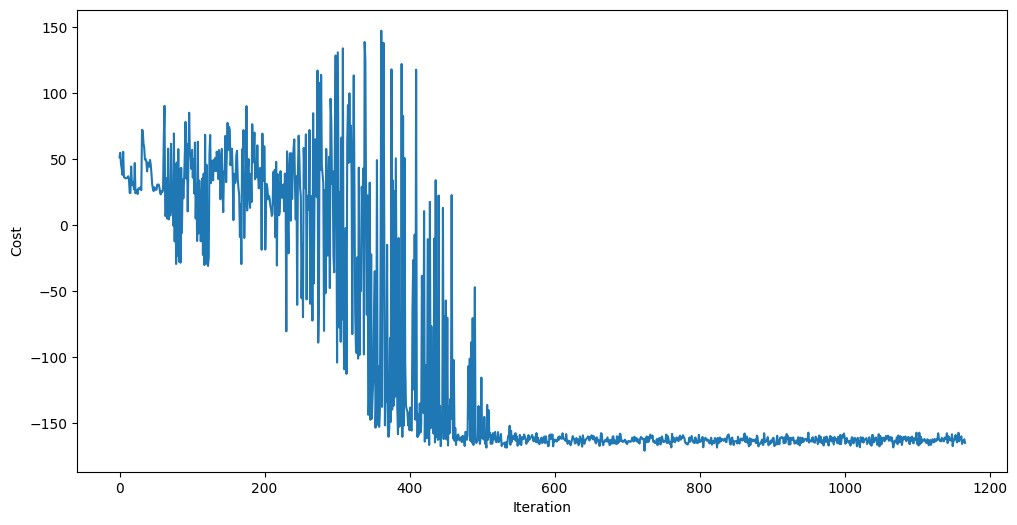

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

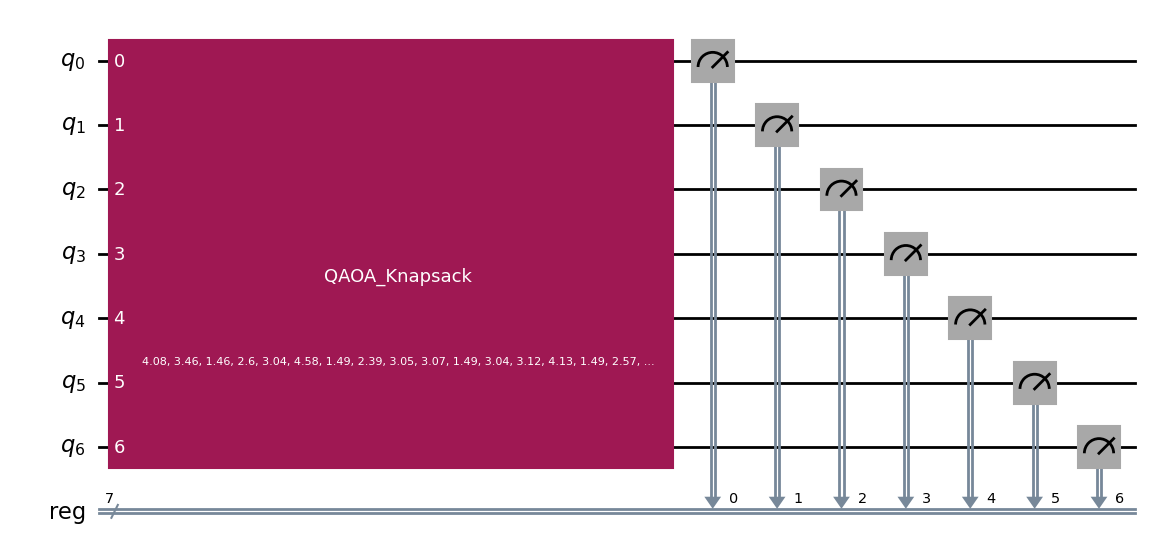

In [21]:
optimized_circuit = qaoa.assign_parameters(result.x)
reg = ClassicalRegister(n_items, 'reg')
optimized_circuit.add_register(reg)
optimized_circuit.measure(qaoa.qubits[0:n_items], reg)
optimized_circuit.draw('mpl')

{'1111010': 0.0382, '1000110': 0.0029, '0111111': 0.0706, '1111000': 0.0117, '0110010': 0.0002, '0101110': 0.0089, '1010111': 0.0101, '0001000': 0.0018, '0001010': 0.0078, '0110001': 0.0028, '0011111': 0.0249, '1110110': 0.0635, '0000100': 0.0082, '0111011': 0.0232, '0000111': 0.0006, '0111001': 0.0134, '1100010': 0.0008, '1011110': 0.03, '0111100': 0.0479, '1010100': 0.0154, '0111101': 0.0475, '1010010': 0.0028, '0011001': 0.0096, '0110111': 0.0161, '1011011': 0.0354, '1000100': 0.007, '0011100': 0.0032, '1001010': 0.0233, '1011000': 0.0085, '0010010': 0.0013, '0011110': 0.0187, '1110100': 0.0098, '0110100': 0.0107, '1100110': 0.0026, '1011010': 0.0149, '0100001': 0.0038, '0101001': 0.0044, '0010111': 0.0056, '1110010': 0.0262, '0010011': 0.0074, '0101100': 0.001, '0011010': 0.0112, '0010110': 0.0034, '1100001': 0.0029, '0100110': 0.0111, '0111010': 0.0069, '0100010': 0.0051, '0111110': 0.0344, '1101000': 0.003, '1000111': 0.0107, '1011001': 0.0142, '0110101': 0.0292, '1010011': 0.014

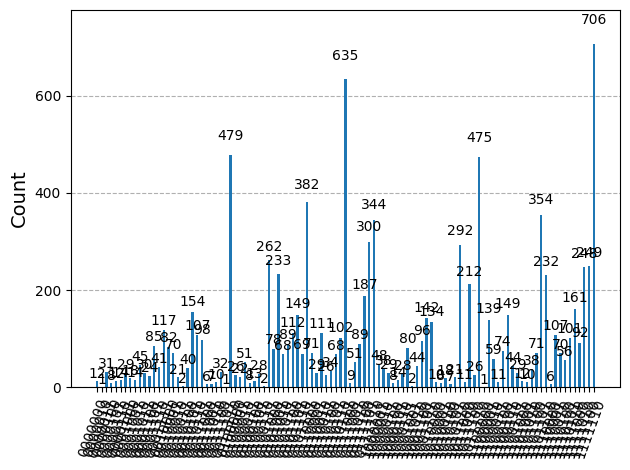

In [22]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Transpilar para el simulador
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(optimized_circuit.decompose().decompose(), simulator)

# Ejecutar el circuito
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

# Obtener conteos
counts = result.get_counts()

# Normalizar los resultados
final_distribution = {key: val/shots for key, val in counts.items()}
final_distribution = {key[::-1]: val for key, val in final_distribution.items()}

print(final_distribution)
print(len(final_distribution))
plot_histogram(counts)

In [23]:
most_probable_solution = max(final_distribution.items(), key=lambda kv: kv[1])
#segunda mas probable solution
print("Most probable solution:", most_probable_solution)   
print("Real solution:", real_solution)

Most probable solution: ('0111111', 0.0706)
Real solution: [1, 1, 1, 1, 1, 1, 0]
